In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from pathlib import Path
import seaborn as sns 
from sklearn.model_selection import train_test_split

# Load Sunspots dataset

In [2]:
DATA_DIR = Path("../data").absolute()
sunspots_df = pd.read_csv(DATA_DIR / "sunspots.csv", index_col=0)
sunspots_df.Date = sunspots_df.Date.astype("datetime64[m]")
sunspots_df.head()


,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


## Explore dataset

In [3]:
sunspots_df = sunspots_df.rename(columns={"Monthly Mean Total Sunspot Number": "sunspots"})

In [4]:
print(f"Number of samples: {len(sunspots_df)}")
print(f"Number of missing values: {sunspots_df.isna().sum().sum()}")
print(f"Number of duplicated values: {sunspots_df.duplicated().sum()}")
print(f"date range: {sunspots_df.Date.min()} - {sunspots_df.Date.max()}")

Number of samples: 3265
Number of missing values: 0
Number of duplicated values: 0
date range: 1749-01-31 00:00:00 - 2021-01-31 00:00:00


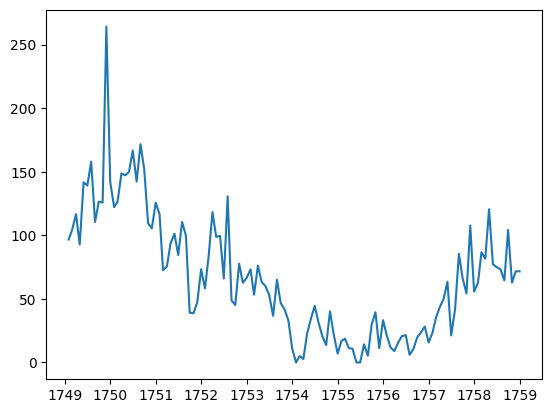

In [5]:
years = 10
plt.plot(sunspots_df.Date.iloc[: years * 12], sunspots_df.sunspots.iloc[: years * 12])

<Axes: >

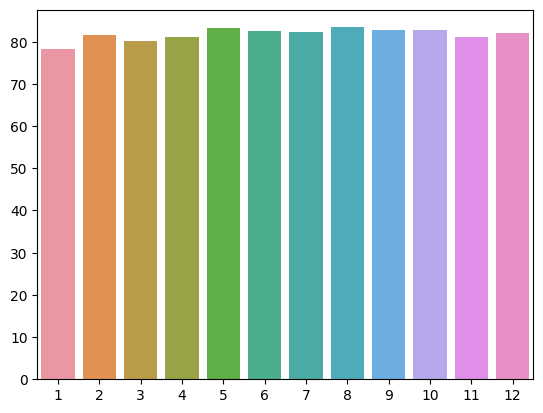

In [6]:
y = sunspots_df.groupby(sunspots_df.Date.dt.month)["sunspots"].mean().values
sns.barplot(x=list(range(1, 13)), y=y)


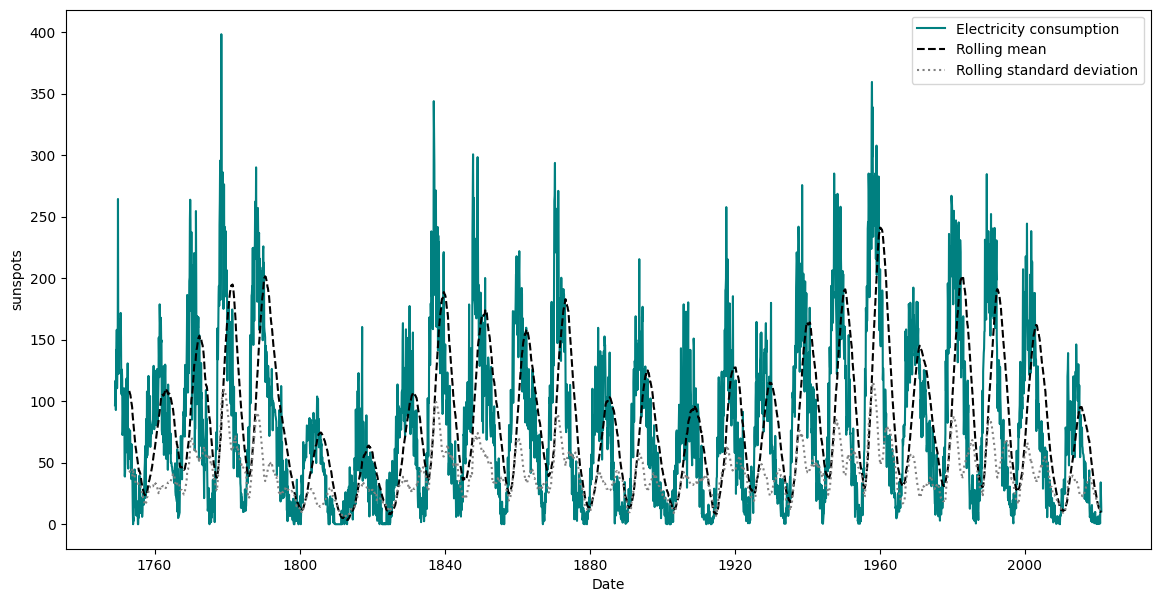

In [7]:
plt.figure(figsize=(14,7))
plt.plot(
    sunspots_df["Date"], sunspots_df["sunspots"], 
    color="teal", label="Electricity consumption"
)
plt.plot(
    sunspots_df["Date"], 
    sunspots_df["sunspots"].rolling(12 * 4).mean(), 
    label="Rolling mean", color="black", linestyle="--"
)
plt.plot(
    sunspots_df["Date"], 
    sunspots_df["sunspots"].rolling(12 * 4).std(), 
    label="Rolling standard deviation", color="gray", linestyle=":"
)
plt.xlabel("Date")
plt.ylabel("sunspots")
plt.legend()

# Train LSTM network

## Model definition

In [8]:
import torch
import torch as th 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything


class LSTMRegressor(pl.LightningModule):

    def __init__(self, 
                 n_features, 
                 hidden_size, 
                 input_seq_len, 
                 output_seq_len,
                 batch_size,
                 num_layers, 
                 dropout, 
                 learning_rate,
                 criterion):
        super(LSTMRegressor, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.input_seq_len = input_seq_len
        self.output_seq_len = output_seq_len
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.criterion = criterion
        self.learning_rate = learning_rate

        self.lstm = nn.LSTM(input_size=n_features, 
                            hidden_size=hidden_size,
                            num_layers=num_layers, 
                            dropout=dropout, 
                            batch_first=True)
        self.linear = nn.Linear(hidden_size, output_seq_len)
        
    def forward(self, x):
        # lstm_out = (batch_size, input_seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)
        y_pred = self.linear(lstm_out[:,-1])
        return y_pred
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

## Prepare data for training

In [9]:
from sklearn.preprocessing import MinMaxScaler

def ts2dataset(values, input_size, output_size, stride=1):
    """
    Convert a time series into a dataset of input/output pairs.

    Parameters:
        values: time series
        input_size: number of time steps to use as input
        output_size: number of time steps to use as output
        stride: number of time steps between each input/output pair
    
    Returns:
        X: input data of shape [n_samples, input_size]
        y: output data of shape [n_samples, output_size]
    """
    X = []
    y = []
    for i in range(0, len(values) - output_size - input_size, stride):
        X.append(values[i : i + input_size])
        y.append(values[i + input_size : i + input_size + output_size])
    return np.array(X), np.array(y)

In [10]:
test_size = 0.2
train_df, test_df = train_test_split(sunspots_df, test_size=test_size, shuffle=False)

scaler = MinMaxScaler()
train_df["sunspots_scaled"] = scaler.fit_transform(train_df[["sunspots"]])
test_df["sunspots_scaled"] = scaler.transform(test_df[["sunspots"]])

INPUT_SEQUENCE_LENGTH = 12 * 4
OUTPUT_SEQUENCE_LENGTH = 1 

X_train, y_train = ts2dataset(
    values=train_df["sunspots_scaled"].values, 
    input_size=INPUT_SEQUENCE_LENGTH, 
    output_size=OUTPUT_SEQUENCE_LENGTH,
    stride=1
)
X_test, y_test = ts2dataset(
    values=test_df["sunspots_scaled"].values,
    input_size=INPUT_SEQUENCE_LENGTH,
    output_size=OUTPUT_SEQUENCE_LENGTH,
    stride=1
)

## Train LSTM

In [11]:
model_lstm = LSTMRegressor(
    n_features=1, 
    hidden_size=64, 
    input_seq_len=INPUT_SEQUENCE_LENGTH, 
    output_seq_len=OUTPUT_SEQUENCE_LENGTH,
    batch_size=32, 
    num_layers=2, 
    dropout=0.1,
    learning_rate=0.01, 
    criterion=nn.MSELoss()
)

train_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(X_train.astype(np.float32)).float().unsqueeze(-1), 
        torch.from_numpy(y_train.astype(np.float32)).float()
    ), 
    batch_size=32, 
    shuffle=True
)
test_loader = DataLoader(
    TensorDataset(
        torch.from_numpy(X_test.astype(np.float32)).float().unsqueeze(-1), 
        torch.from_numpy(y_test.astype(np.float32)).float()
    ), 
    batch_size=32, 
    shuffle=True
)

In [ ]:
trainer = Trainer(max_epochs=400)
trainer.fit(model_lstm, train_loader, test_loader)

/Users/czyjtu/dev/time-series-forecasting/venv/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


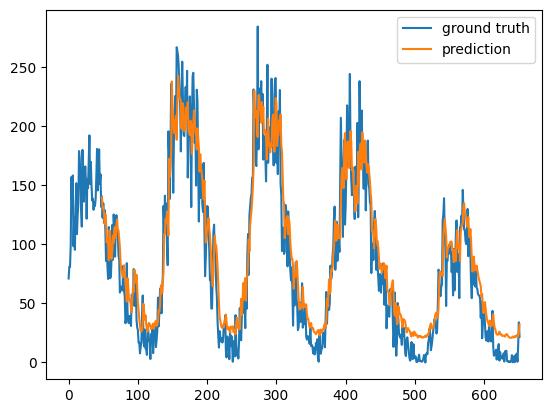

MSE: 0.0038


In [13]:
def plot_predictions(model, test_series, input_size, output_size, scaler):
    X, y = ts2dataset(test_series, input_size, output_size, stride=output_size)
    X = scaler.transform(X.reshape(-1, 1)).reshape(-1, input_size)
    X = torch.from_numpy(X).float().unsqueeze(-1)
    y = torch.from_numpy(y).float()
    model.eval()
    with torch.no_grad():
        y_hat = model(X).detach().numpy()
    y_hat = y_hat.reshape(-1, 1)
    y_hat = scaler.inverse_transform(y_hat).flatten()

    prediction_len = input_size + len(y_hat)
    plt.plot(np.arange(prediction_len), test_series[:prediction_len], label="ground truth")
    plt.plot(np.arange(input_size, prediction_len), y_hat, label="prediction")
    plt.legend()
    plt.show()


plot_predictions(model_lstm, test_df.sunspots.values, INPUT_SEQUENCE_LENGTH, OUTPUT_SEQUENCE_LENGTH, scaler)
with th.no_grad():
    model_lstm.eval()
    y_hat = model_lstm(torch.from_numpy(X_test.astype(np.float32)).float().unsqueeze(-1)).detach().numpy()
mse = ((y_hat - y_test) ** 2).mean()
print(f"MSE: {mse:.4f}")

# Train ESN

In [17]:
from torchesn.nn import ESN
from torchesn import utils
import torch as th 

In [20]:
import torch.nn
import numpy as np
from torchesn.nn import ESN
from torchesn import utils
import time

device = "cpu"
dtype = torch.double
torch.set_default_dtype(dtype)

lag = 1
X_data = train_df["sunspots_scaled"].iloc[: -lag].values.reshape(-1, 1, 1)
Y_data =train_df["sunspots_scaled"].iloc[lag: ].values.reshape(-1, 1, 1)
X_data = torch.from_numpy(X_data).to(device)
Y_data = torch.from_numpy(Y_data).to(device)

trX = X_data
trY = Y_data
tsX = th.from_numpy(test_df["sunspots_scaled"].iloc[: -lag].values.reshape(-1, 1, 1))
tsY = th.from_numpy(test_df["sunspots_scaled"].iloc[lag: ].values.reshape(-1, 1, 1))

washout = [100]
input_size = output_size = 1
hidden_size = 500
loss_fcn = torch.nn.MSELoss()



start = time.time()

# Training
trY_flat = utils.prepare_target(trY.clone(), [trX.size(0)], washout)

model = ESN(input_size, hidden_size, output_size)
model.to(device)

model(trX, washout, None, trY_flat)
model.fit()
output, hidden = model(trX, washout)
print("Training error:", loss_fcn(output, trY[washout[0]:]).item())

# Test
output, hidden = model(tsX, [0], hidden)
print("Test error:", loss_fcn(output, tsY).item())
print("Ended in", time.time() - start, "seconds.")

Training error: 0.002445352945837589
Test error: 0.005205642858624564
Ended in 0.45778322219848633 seconds.


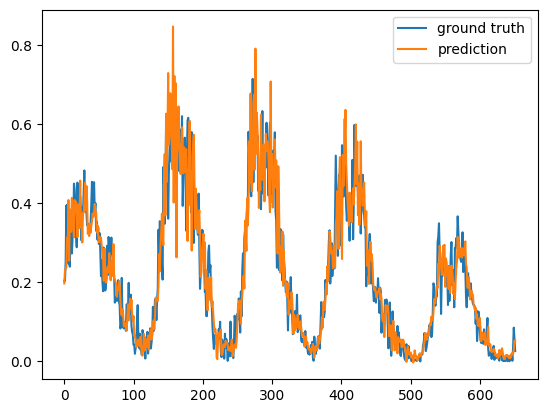

In [21]:
plt.plot(np.arange(len(tsY)), tsY.detach().numpy().flatten(), label="ground truth")
plt.plot(np.arange(len(tsY)), output.detach().numpy().flatten(), label="prediction")
plt.legend()
plt.show()

torch.Size([553])


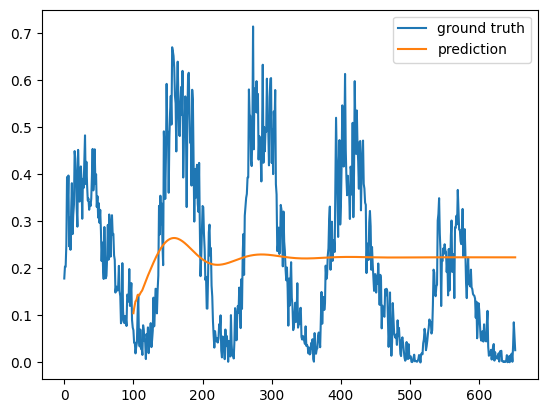

In [40]:
from auto_esn.esn.esn import DeepESN 
import auto_esn.utils.dataset_loader as dl
from auto_esn.datasets.df import Sunspot
from auto_esn.esn.reservoir.initialization import CompositeInitializer, WeightInitializer
from auto_esn.esn.reservoir.util import NRMSELoss
from matplotlib import pyplot as plt

def generate_autoregressive_forecast(model, X_initial, horizon) -> th.Tensor:
    X_input = X_initial.clone()
    predictions = []
    for _ in range(horizon):
        # model.reservoir.esn_cell.reset_hidden()
        next_val = model(X_input)
        X_input = th.roll(X_input, -1, 0)
        X_input[-1] = next_val[-1]
        predictions.append(next_val[-1])
    return th.cat(predictions)


i = CompositeInitializer()\
    .with_seed(12)\
    .uniform()\
    .regular_graph(4)\
    .spectral_normalize()\
    .scale(0.9)

w = WeightInitializer()
w.weight_hh_init = i
esn = DeepESN(initializer= w, hidden_size=500, num_layers=2)

lag = 1
X_train = th.from_numpy(train_df["sunspots_scaled"].iloc[: -lag].values.reshape(-1, 1))
y_train = th.from_numpy(train_df["sunspots_scaled"].iloc[lag: ].values.reshape(-1, 1))
X_test = th.from_numpy(test_df["sunspots_scaled"].values.reshape(-1, 1))

esn.fit(X_train, y_train)

initial_sequence_length = 100
X_input = X_test[: initial_sequence_length]
y_pred = generate_autoregressive_forecast(esn, X_input, X_test.shape[0] - initial_sequence_length)
print(y_pred.shape)
plt.plot(np.arange(len(X_test)), X_test.detach().numpy().flatten(), label="ground truth")
plt.plot(np.arange(initial_sequence_length, len(X_test)), y_pred.detach().numpy().flatten(), label="prediction")
plt.legend()
plt.show()
